### AH2036 Railway Planning and Operations - Project Assignment
#### Jesús Salvador Martínez Alcaide

In [1]:
from pulp import LpProblem, LpMinimize, LpVariable, lpSum
from pulp import GUROBI

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, time
import numpy as np


# Change scenario
scenarios_df = pd.read_csv("Data/scenarios.csv", delimiter = ";")
scenario_name = 'EL-R30'
scenario = scenarios_df[scenarios_df['Scenario'] == scenario_name] 

# Values for optimization
num_days = 320
num_units = 10 ## Maximum number of units to consider for each train type
num_services = scenario['Number of Departures'].iloc[0] * 2
distance_per_trip = scenario['Distance'].iloc[0]
minutes_next_service = scenario['Minutes Between Service'].iloc[0] # At least 2h will pass from each train starting a service to starting the next one
travel_time = scenario['Travel Times'].iloc[0]


## Parameters for plotting circulation plan
starting_time = time(6,0) ## Start of the day
ending_time = time(23,59) ## End of the day
circulation_plan_travel_time = travel_time
circulation_plan_title = "Circulation Plan " + scenario_name + " Asymmetric Demand"
circulation_plan_file_name = "/Asymmetric/circulation_plan_" + scenario_name + "_asymmetric.jpg"


## Read files for demand, train characteristics and timetable
demand_file_name = scenario['Demand File'].iloc[0]
trains_file_name = scenario['Trains File'].iloc[0]
timetable_file_name = scenario['Timetable File'].iloc[0]

demand_df = pd.read_csv("data/demand/" + "asymmetric/" + str(demand_file_name),delimiter = ";")
train_df = pd.read_csv("data/trains/" + str(trains_file_name),delimiter = ";")
timetable_linköping_df = pd.read_excel("data/Timetable/" + str(timetable_file_name), sheet_name = "Linköping")
timetable_stockholm_df = pd.read_excel("data/Timetable/" + str(timetable_file_name), sheet_name = "Stockholm")


demand = demand_df['Demand'].to_list()

train_df['yearly_variable_cost'] = train_df['Cost per km']  * distance_per_trip * num_days

trains_names = train_df['Name'].to_list()
trains_seats = train_df['Seats'].to_list()
trains_variable_costs =  train_df['yearly_variable_cost'].to_list()
trains_capital_costs = train_df['Capital Cost'].to_list()



In [2]:
## Extract cooldown from timetable data
timetable_linköping_df["Departure Time"] = pd.to_datetime(timetable_linköping_df["Departure Time"], format="%H:%M:%S")
timetable_linköping_df["Next Service"] = timetable_linköping_df["Departure Time"] + pd.Timedelta(minutes=minutes_next_service)
timetable_linköping_df["Arrival Time"] = timetable_linköping_df["Departure Time"] + pd.Timedelta(minutes=circulation_plan_travel_time)
timetable_linköping_df["Departure Time"] = timetable_linköping_df["Departure Time"].dt.time
timetable_linköping_df["Next Service"] = timetable_linköping_df["Next Service"].dt.time
timetable_linköping_df["Arrival Time"] = timetable_linköping_df["Arrival Time"].dt.time

timetable_stockholm_df["Departure Time"] = pd.to_datetime(timetable_stockholm_df["Departure Time"], format="%H:%M:%S")
timetable_stockholm_df["Next Service"] = timetable_stockholm_df["Departure Time"] +  pd.Timedelta(minutes=minutes_next_service)
timetable_stockholm_df["Arrival Time"] = timetable_stockholm_df["Departure Time"] +  pd.Timedelta(minutes=circulation_plan_travel_time)
timetable_stockholm_df["Departure Time"] = timetable_stockholm_df["Departure Time"].dt.time
timetable_stockholm_df["Next Service"] = timetable_stockholm_df["Next Service"].dt.time
timetable_stockholm_df["Arrival Time"] = timetable_stockholm_df["Arrival Time"].dt.time

timetable_linköping_merged_df = timetable_linköping_df.merge(right = timetable_stockholm_df,how = 'left',left_on = 'Next Service', right_on = 'Departure Time', suffixes = (None,"_sto"))
timetable_linköping_merged_df.bfill(inplace = True) # Take next value when the next service is not available

timetable_linköping_merged_df['Cooldown'] = timetable_linköping_merged_df['Id_sto'] - timetable_linköping_merged_df['Id'] 
timetable_linköping_merged_df['Cooldown'] = timetable_linköping_merged_df['Cooldown'].fillna(num_services - timetable_linköping_merged_df['Id'])

timetable_stockholm_merged_df = timetable_stockholm_df.merge(right = timetable_linköping_df,how = 'left',left_on = 'Next Service', right_on = 'Departure Time', suffixes = (None,"_lin"))
timetable_stockholm_merged_df.bfill(inplace = True) # Take next value when the next service is not available

timetable_stockholm_merged_df['Cooldown'] = timetable_stockholm_merged_df['Id_lin'] - timetable_stockholm_merged_df['Id'] 
timetable_stockholm_merged_df['Cooldown'] = timetable_stockholm_merged_df['Cooldown'].fillna(num_services - timetable_stockholm_merged_df['Id'])

cooldown_merged_df = pd.concat([timetable_linköping_merged_df[['Id','Cooldown','Departure Time','Arrival Time']],timetable_stockholm_merged_df[['Id','Cooldown','Departure Time','Arrival Time']]])
cooldown_merged_df = cooldown_merged_df.sort_values(by=['Id'], ascending = True)
cooldown = (cooldown_merged_df['Cooldown'].astype(int).to_list())
cooldown_merged_df

,Id,Cooldown,Departure Time,Arrival Time
0,0,9.0,06:10:00,07:35:00
0,1,7.0,06:10:00,07:35:00
1,2,9.0,06:40:00,08:05:00
1,3,7.0,06:40:00,08:05:00
2,4,9.0,07:10:00,08:35:00
2,5,7.0,07:10:00,08:35:00
3,6,9.0,07:40:00,09:05:00
3,7,7.0,07:40:00,09:05:00
4,8,9.0,08:10:00,09:35:00
4,9,7.0,08:10:00,09:35:00


In [3]:
# Problem definition
problem = LpProblem("Railway_Cost_Minimization", LpMinimize)


# Decision variables for each service
units_range = list(range(num_units))
services_range = list(range(num_services))

service_vars = {
    (t, i, j): LpVariable(f"{t}_{i}_{j}", cat="Binary") for t in trains_names for i in units_range for j in services_range
}

unit_vars = {
    (t, i): LpVariable(f"{t}_{i}", cat="Binary") for t in trains_names for i in units_range
}



# Objective function: Minimize total cost
problem += lpSum([
    service_vars[t,i,j] * trains_variable_costs[index] for index,t in enumerate(trains_names) for i in units_range for j in services_range
]) + lpSum([
    unit_vars[t,i] * trains_capital_costs[index] for index,t in enumerate(trains_names) for i in units_range
])

In [4]:
# Constraints
# 1. Capacity must be larger than demand
for j in services_range:
    problem += lpSum([service_vars[t,i,j] * trains_seats[index] for index,t in enumerate(trains_names) for i in units_range]) >= demand[j], f"Service_{j}_Coverage"


# 2. If a unit within a service is used, then that unit should be bought 
M = 1000000 ## A very large constant
for i in units_range:
    for t in trains_names:
        problem += lpSum([service_vars[t,i,j] for j in services_range]) <= M * unit_vars[t,i], f"Buying_unit_{i}_{t}" 

# 3. A train has to wait a full round of services to be used again
for i in units_range:
    for j in services_range:
        for t in trains_names:
            problem += lpSum([service_vars[t,i,k] for k in range(j, j + cooldown[j]) if (k < num_services) & (((j % 2) != (k % 2)) | (j == k)) ]) <= 1, f"Repeating_unit_{i}_{j}_{j+cooldown[j]}_{t}" 


# 4. A train that it is used in Linköping has to come from Stockholm or viceversa
for i in units_range:
    for j in services_range:
        for k in range(j+1):
            for t in trains_names:
                problem += lpSum([service_vars[t,i,l] for l in range(k,j+1) if (l % 2 == 0)]) - \
                           lpSum([service_vars[t,i,l] for l in range(k,j+1) if (l % 2 != 0)]) <= 1, f"Consistent_unit_{i}_{j}_{k}_{t}_a"
                problem += lpSum([service_vars[t,i,l] for l in range(k,j+1) if (l % 2 != 0)]) - \
                           lpSum([service_vars[t,i,l] for l in range(k,j+1) if (l % 2 == 0)]) <= 1, f"Consistent_unit_{i}_{j}_{k}_{t}_b"
                
#5. The number of trains in each endpoint has to be the same as the initial one

for t in trains_names:
    problem += lpSum([service_vars[t,i,j] for i in units_range for j in services_range if (j % 2 == 0)]) -\
               lpSum([service_vars[t,i,j] for i in units_range for j in services_range if (j % 2 != 0)]) == 0,f"Consistent_start_end_{t}"
                 
                  
# 6. Use lower units first
for i in units_range:
    for t in trains_names:
        problem += lpSum(unit_vars[t,j] for j in range(i+1, num_units)) <= M * unit_vars[t,i], f"Ordering_unit_{i}_{t}"



In [5]:
# Solve the problem
problem.solve(GUROBI(msg=True))

Set parameter Username
Set parameter LicenseID to value 2615643
Academic license - for non-commercial use only - expires 2026-01-27
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 74502 rows, 1220 columns and 1521650 nonzeros
Model fingerprint: 0x70c02151
Variable types: 0 continuous, 1220 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [5e+06, 1e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 23962 rows and 0 columns (presolve time = 5s)...
Presolve added 0 rows and 2640 columns
Presolve removed 22710 rows and 0 columns
Presolve time: 7.13s
Presolved: 51792 rows, 3860 columns, 953602 nonzeros
Variable types: 0 continuous, 3860 integer (1220 binary)
Found heuristic solution: ob

1

In [6]:
# Output results
print("Status:", problem.status)
print("Optimal solution found:")

trains_long_names = train_df['Long Name'].to_list()

for (index,t) in enumerate(trains_names):
    for i in units_range:
        for j in services_range:
            if service_vars[t,i,j].varValue == 1:
                print(f"{trains_long_names[index]} Unit {i}, Service {j}")

        
print(f"Minimum total cost: {problem.objective.value():.2f} SEK")


Status: 1
Optimal solution found:
GIR-C3 Unit 0, Service 5
GIR-C3 Unit 0, Service 12
GIR-C3 Unit 0, Service 21
GIR-C3 Unit 0, Service 28
GIR-C3 Unit 0, Service 39
GIR-C3 Unit 0, Service 46
GIR-C3 Unit 0, Service 55
GIR-C3 Unit 1, Service 4
GIR-C3 Unit 1, Service 15
GIR-C3 Unit 1, Service 22
GIR-C3 Unit 1, Service 31
GIR-C3 Unit 1, Service 38
GIR-C3 Unit 1, Service 49
GIR-C3 Unit 1, Service 56
GIR-C3 Unit 2, Service 6
GIR-C3 Unit 2, Service 19
GIR-C3 Unit 2, Service 26
GIR-C3 Unit 2, Service 35
GIR-C3 Unit 2, Service 42
GIR-C3 Unit 2, Service 51
GIR-C3 Unit 3, Service 6
GIR-C3 Unit 3, Service 17
GIR-C3 Unit 3, Service 24
GIR-C3 Unit 3, Service 33
GIR-C3 Unit 3, Service 40
GIR-C3 Unit 3, Service 53
GIR-C3 Unit 3, Service 58
GIR-C3 Unit 4, Service 7
GIR-C3 Unit 4, Service 14
GIR-C3 Unit 4, Service 23
GIR-C3 Unit 4, Service 30
GIR-C3 Unit 4, Service 39
GIR-C3 Unit 4, Service 48
GIR-C3 Unit 4, Service 57
GIR-C3 Unit 5, Service 9
GIR-C3 Unit 5, Service 16
GIR-C3 Unit 5, Service 25
GIR-C3 Uni

In [7]:
for j in services_range:
    for i in units_range:
        for t in trains_names:
            if service_vars[t,i,j].varValue == 1:
                print(f"Service {j} Type {t} Unit {i}")


Service 0 Type C4 Unit 3
Service 1 Type C4 Unit 0
Service 2 Type C4 Unit 2
Service 3 Type C4 Unit 1
Service 4 Type C3 Unit 1
Service 4 Type C3 Unit 6
Service 5 Type C3 Unit 0
Service 6 Type C3 Unit 2
Service 6 Type C3 Unit 3
Service 7 Type C3 Unit 4
Service 8 Type C4 Unit 0
Service 9 Type C3 Unit 5
Service 10 Type C4 Unit 1
Service 11 Type C4 Unit 3
Service 12 Type C3 Unit 0
Service 13 Type C3 Unit 6
Service 14 Type C3 Unit 4
Service 15 Type C3 Unit 1
Service 16 Type C3 Unit 5
Service 17 Type C3 Unit 3
Service 18 Type C4 Unit 3
Service 19 Type C3 Unit 2
Service 20 Type C3 Unit 6
Service 21 Type C3 Unit 0
Service 22 Type C3 Unit 1
Service 23 Type C3 Unit 4
Service 24 Type C3 Unit 3
Service 25 Type C3 Unit 5
Service 26 Type C3 Unit 2
Service 27 Type C4 Unit 1
Service 28 Type C3 Unit 0
Service 29 Type C3 Unit 6
Service 30 Type C3 Unit 4
Service 31 Type C3 Unit 1
Service 32 Type C3 Unit 5
Service 33 Type C3 Unit 3
Service 34 Type C4 Unit 1
Service 35 Type C3 Unit 2
Service 36 Type C3 Unit 

In [40]:
import matplotlib.cm as cm

## Function to build a circulation plan
def build_circulation_plan(input_df, origin, destination, distance, plot_title, out_file_path = "", save_file = False):
    df = input_df.copy()
    df['ttime'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time

    
    units = df['Unit'].unique()
    plt.figure(figsize=(16, 9))

    cmap = plt.get_cmap("tab20")  



    
    for index,unit in enumerate(units):
        x = df[df['Unit'] == unit]['ttime']
        y = df[df['Unit'] == unit]['Position']


        x = [datetime.combine(datetime.today(), t) for t in x]

        
        plt.plot(x, y, label=f"{unit}", color = cmap(index))


    plt.axhline(y=0, color='red', linestyle='--')
    plt.axhline(y=distance, color='blue', linestyle='--')
    
    text_time = datetime.combine(datetime.today(), time(5, 50))
    plt.text(text_time, 0, origin, color='red', va='center', ha='right', fontsize=10, backgroundcolor='white')
    plt.text(text_time, distance, destination, color='blue', va='center', ha='right', fontsize=10, backgroundcolor='white')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.HourLocator())
    plt.gcf().autofmt_xdate()
    
    plt.xlabel("")
    plt.ylabel("")
    
    plt.gca().set_yticks([])
    
    plt.legend()
    plt.title(plot_title)
    plt.grid(axis='x')

    if save_file:
        plt.savefig(out_file_path, format='jpg', dpi=300, bbox_inches='tight')
        
    plt.show()


In [9]:
trains_long_names = train_df['Long Name'].to_list()

timetable_list = []
#station_offset = 5
random_offset = np.random.uniform(3, 30)

for (index,t) in enumerate(trains_names):
    for i in units_range:
        if unit_vars[t,i].varValue == 0: # Skip iteration since the unit is never used
            continue
        first_service = True
        last_service = 0
        unit_name = trains_long_names[index] + " Unit " + str(i)
        starting_position = 0
        ending_position = 0
        time_overlapping_offset = 0
        for j in services_range:
            if service_vars[t,i,j].varValue == 0:
                continue # Skip iteration if the unit does not run the current service
            if j % 2 == 0:
                offset_sign = -1
                starting_position = 0
                ending_position = distance_per_trip
            else:
                offset_sign = 1
                starting_position = distance_per_trip
                ending_position = 0
                
            if first_service:
                timetable_list.append({"Unit": unit_name, "Time": starting_time, "Position": starting_position + offset_sign * random_offset})
                first_service = False
            other_service_for_j = sum(service_vars[T, I, j].varValue for (index_2,T) in enumerate(trains_names) for I in units_range if (I < i and index == index_2) or (index < index_2))
                                      
            if other_service_for_j > 0:
                time_overlapping_offset = 3
            else:
                time_overlapping_offset = 0
            
            departure_time_raw= cooldown_merged_df[cooldown_merged_df['Id'] == j]['Departure Time'].iloc[0]
            arrival_time_raw = cooldown_merged_df[cooldown_merged_df['Id'] == j]['Arrival Time'].iloc[0]
            departure_time = (pd.to_datetime(departure_time_raw, format="%H:%M:%S") +  pd.Timedelta(minutes=time_overlapping_offset)).time()
            arrival_time = (pd.to_datetime(arrival_time_raw, format="%H:%M:%S") +  pd.Timedelta(minutes=time_overlapping_offset)).time()

            timetable_list.append({"Unit": unit_name, "Time": departure_time, "Position": starting_position + offset_sign * random_offset})
            timetable_list.append({"Unit": unit_name, "Time": departure_time, "Position": starting_position})
            random_offset = np.random.uniform(3, 30) 
            timetable_list.append({"Unit": unit_name, "Time": arrival_time, "Position": ending_position})
            timetable_list.append({"Unit": unit_name, "Time": arrival_time, "Position": ending_position  - offset_sign * random_offset})
            last_service = j
                
        if last_service % 2 == 0:      
            ending_position = distance_per_trip
        else:
            ending_position = 0

        timetable_list.append({"Unit": unit_name, "Time": ending_time, "Position": ending_position  - offset_sign * random_offset})

timetable_circulation_plan_df = pd.DataFrame(timetable_list)
timetable_circulation_plan_df

,Unit,Time,Position
0,GIR-C3 Unit 0,06:00:00,218.856668
1,GIR-C3 Unit 0,07:10:00,218.856668
2,GIR-C3 Unit 0,07:10:00,202.000000
3,GIR-C3 Unit 0,08:35:00,0.000000
4,GIR-C3 Unit 0,08:35:00,-14.587925
...,...,...,...
273,GIR-C4 Unit 3,17:10:00,-28.818405
274,GIR-C4 Unit 3,17:10:00,0.000000
275,GIR-C4 Unit 3,18:35:00,202.000000
276,GIR-C4 Unit 3,18:35:00,221.476511


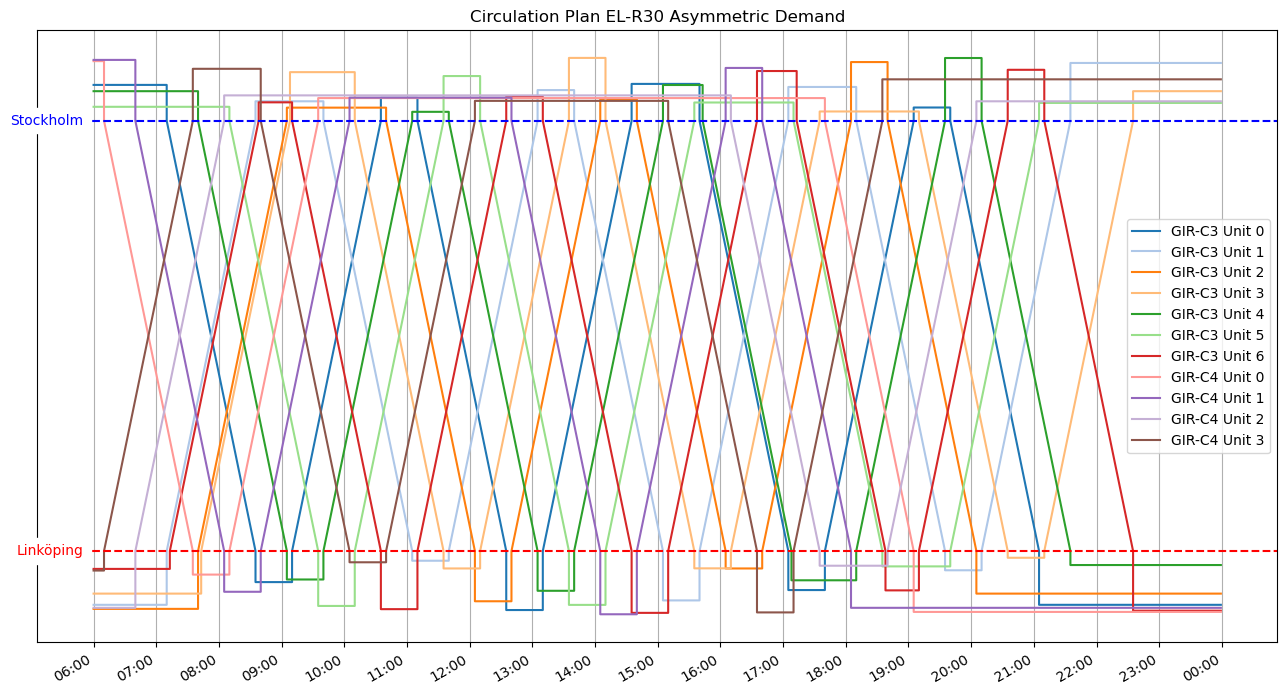

In [38]:
build_circulation_plan(input_df = timetable_circulation_plan_df, origin = "Linköping", destination = "Stockholm",  
                       distance = distance_per_trip, 
                       plot_title = circulation_plan_title, 
                       out_file_path = "Circulation_Plans/" + circulation_plan_file_name, 
                       save_file = True)